<a href="https://colab.research.google.com/github/zarakkhan36/GenAI/blob/main/problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧱 LSUN Bedroom Dataset

In [1]:
# Zarak Khan
# The purpose of this assignment is to build and train a GAN using the LSUN dataset, and generate realistic bedroom images using what is learned by the training data

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
)


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
Z_DIM = 100

EPOCHS = 20

LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [3]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to uploaded file
zip_file_path = '/content/drive/My Drive/archive (2).zip'
extract_to = '/content/dataset'  # Folder to extract the contents

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Function to collect all image files from a directory
def collect_image_files(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif')
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files

# Collect all image files from the extracted folder
image_files = collect_image_files('/content/dataset')
print(f"Found {len(image_files)} image files.")






Mounted at /content/drive
Found 155958 image files.


In [4]:
train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 155958 files belonging to 1 classes.


In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
# make sure utils.py is in colab
# https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/utils.py

from utils import display, sample_batch

train_sample = sample_batch(train)

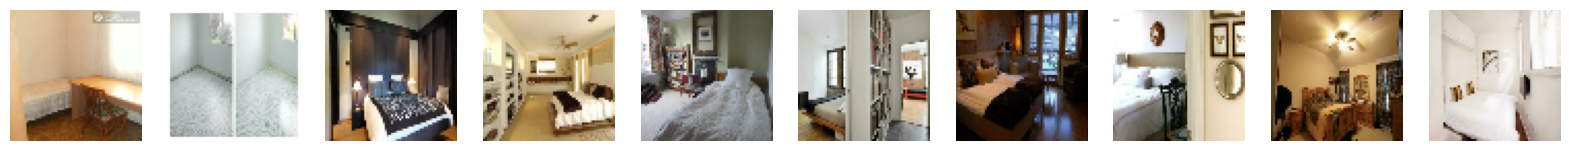

In [9]:
display(train_sample)  # Display the training sample

## 2. Build the GAN <a name="build"></a>

In [9]:

# Define input shape
def make_discriminator_model():
    discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

    # First convolutional layer
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Second convolutional layer, doubling number of filters
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Third convolutional layer, doubling number of filters
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Fourth convolutional layer, doubling number of filters
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Final convolutional layer, sigmoid activation to determine whether input is real or fake
    x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid")(x)

    # Flatten output for binary classification
    discriminator_output = layers.Flatten()(x)

    # Create the discriminator model
    discriminator = models.Model(discriminator_input, discriminator_output)

    return discriminator

# Create the discriminator model
discriminator = make_discriminator_model()

# Display model summary
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
# Reshape the input
x = layers.Reshape((1, 1, Z_DIM))(generator_input)

# Transpose all convolutional layers, batch normalization to stabilize activations
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",

    # Create the generator model
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [11]:

# Discriminator is trained to distinguish between real and generated images
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

## 3. Train the GAN <a name="train"></a>

In [13]:

# Compiles the DCGAN model with Adam optimizers
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [14]:
# Callback to generate images at the end of each epoch
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()


In [15]:

# Train DCGAN model for 20 epochs using image generator
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/20
1219/1219 [==============================] - 597s 487ms/step - d_loss: 0.1537 - d_real_acc: 0.8617 - d_fake_acc: 0.8813 - d_acc: 0.8715 - g_loss: 3.4447 - g_acc: 0.1187
Epoch 2/20
1219/1219 [==============================] - 593s 486ms/step - d_loss: -0.1120 - d_real_acc: 0.9354 - d_fake_acc: 0.9407 - d_acc: 0.9380 - g_loss: 5.7709 - g_acc: 0.0593
Epoch 3/20
1219/1219 [==============================] - 589s 483ms/step - d_loss: -0.2768 - d_real_acc: 0.9526 - d_fake_acc: 0.9559 - d_acc: 0.9543 - g_loss: 8.7089 - g_acc: 0.0441
Epoch 4/20
1219/1219 [==============================] - 587s 481ms/step - d_loss: -0.3662 - d_real_acc: 0.9636 - d_fake_acc: 0.9668 - d_acc: 0.9652 - g_loss: 10.1318 - g_acc: 0.0332
Epoch 5/20
1219/1219 [==============================] - 584s 479ms/step - d_loss: -0.4702 - d_real_acc: 0.9719 - d_fake_acc: 0.9750 - d_acc: 0.9735 - g_loss: 11.4866 - g_acc: 0.0250
Epoch 6/20
1219/1219 [==============================] - 580s 476ms/step - d_loss: -0.5312 - d_

## 3. Generate new images <a name="decode"></a>

In [16]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [17]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 197ms/step


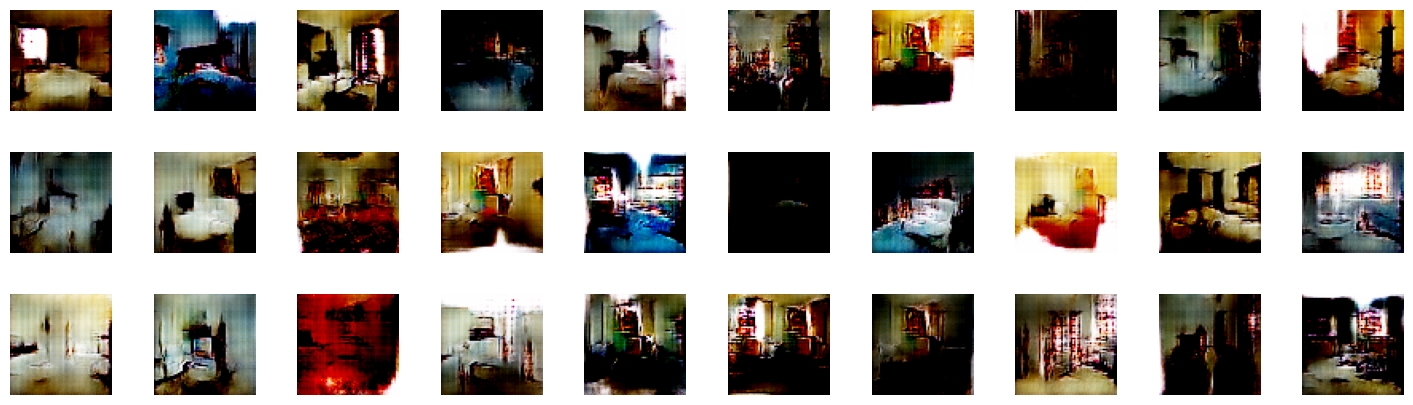

In [18]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [19]:
# Compares how much two images differ in terms of pixels

def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [20]:
# Collects all data from the TensorFlow dataset into a single NumPy array.

all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 44ms/step


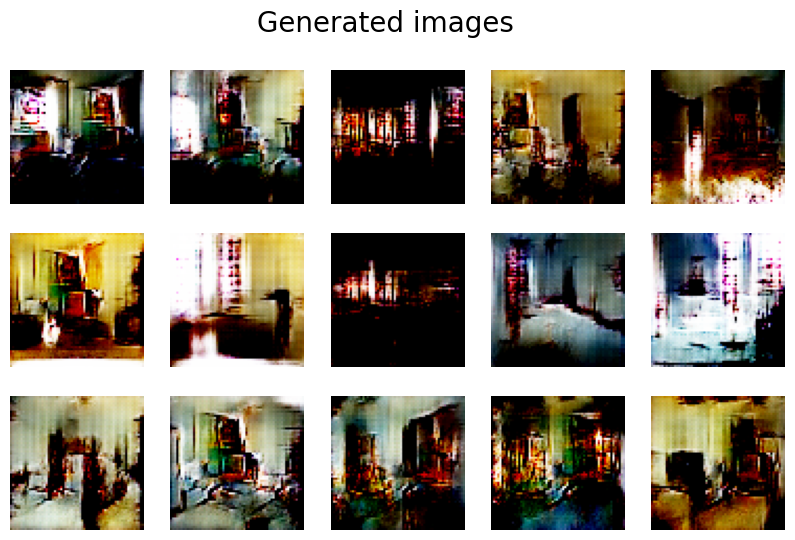

In [21]:

# Uses the generator to create images from the noise vectors

r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

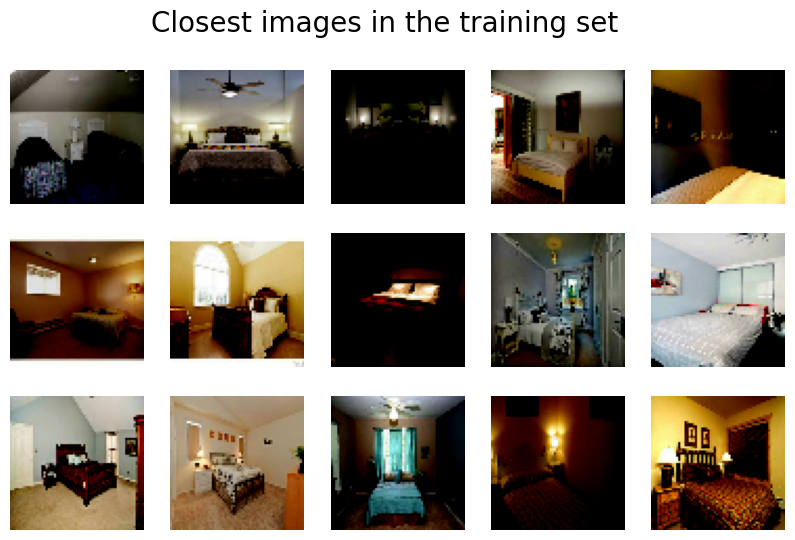

In [22]:
# use the generator to create images and plots them in a grid


fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()